In [1]:
__depends__=[]
__dest__="../results/f8.eps"

# Plot Terms in the Two-fluid EBTEL Equations
As part of our derivation of the two-fluid EBTEL equations, we'll plot the different terms of the two-fluid electron energy equation,
$$
\frac{L}{\gamma - 1}\frac{dp_e}{dt} = \psi_{TR} - (\mathcal{R}_C + \mathcal{R}_{TR}) + \frac{L}{\gamma - 1}k_Bn\nu_{ei}(T_i - T_e) + LQ_e.
$$
We want to plot each term as a function of time to show their relative contributions to the evolution of the electron energy.

In [2]:
import sys
import os
import subprocess

import numpy as np
import seaborn.apionly as sns
import astropy.constants as const
from matplotlib import ticker
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.environ['EXP_DIR'],'ebtelPlusPlus/rsp_toolkit/python'))
from xml_io import InputHandler,OutputHandler

%matplotlib inline

In [3]:
plt.rcParams.update({'figure.figsize' : [8,5]})

Configure the EBTEL run. We'll use $\tau=200$ s and $H_0=0.1$ erg cm$^{-3}$ s$^{-1}$, $L=40$ Mm, and Spitzer conduction.

In [4]:
ih = InputHandler(os.path.join(os.environ['EXP_DIR'],'ebtelPlusPlus','config','ebtel.example.cfg.xml'))
config_dict = ih.lookup_vars()

In [5]:
config_dict['calculate_dem'] = False
config_dict['save_terms'] = True
config_dict['use_flux_limiting'] = True
config_dict['use_adaptive_solver'] = True
config_dict['heating']['partition'] = 1.0
config_dict['heating']['background'] = 3.5e-5
config_dict['heating']['events'] = [
    {'event':{'magnitude':0.1,'rise_start':0.0,'rise_end':100.0,'decay_start':100.0,'decay_end':200.0}}
]
config_dict['total_time'] = 5000.0
config_dict['tau'] = 0.1
config_dict['adaptive_solver_error'] = 1.0e-9
config_dict['saturation_limit'] = 1.0
config_dict['c1_cond0'] = 6.0
config_dict['c1_rad0'] = 0.6
config_dict['use_c1_grav_correction'] = True
config_dict['use_c1_loss_correction'] = True
config_dict['output_filename'] = '../results/_tmp_'

In [6]:
oh = OutputHandler(config_dict['output_filename']+'.xml',config_dict)
oh.print_to_xml()

Run the model.

In [7]:
subprocess.call([os.path.join(os.environ['EXP_DIR'],'ebtelPlusPlus','bin','ebtel++.run'),'-c',oh.output_filename])

0

Load the data.

In [8]:
data = np.loadtxt(oh.output_dict['output_filename'])
t = data[:,0]
Te = data[:,1]
Ti = data[:,2]
n = data[:,3]
q = data[:,-1]
data = np.loadtxt(oh.output_dict['output_filename']+'.terms')
fce = data[:,0]
fci = data[:,1]
r3 = data[:,2]
rad = data[:,3]

Define a function to calculate the Coulomb collision frequency according to [Braginskii (1965)](http://adsabs.harvard.edu/abs/1965RvPP....1..205B).

In [9]:
def calc_nu_ei(n,Te):
    c1 = 16.*np.sqrt(np.pi)/3.
    c2 = const.e.gauss.value**4/(const.m_e.cgs.value*const.m_p.cgs.value)
    c3 = 2.*const.k_B.cgs.value*Te/const.m_e.cgs.value
    colLog = 20.
    return c1*c2*c3**(-3./2.)*n*colLog

Calculate the terms as given in the equation above.

In [10]:
delta_terms = []
delta_terms.append(fce/(config_dict['loop_length'])/(1.+Te/Ti))
delta_terms.append(-fci/(config_dict['loop_length'])*(Te/Ti)/(1.+Te/Ti))
delta_terms.append(-(Te/Ti*(r3+1.) + 1.)/(1.+Te/Ti)*n**2*rad)
#delta_terms.append(q)
tmp = np.zeros(len(Te))
for i in range(len(Te)):
    tmp[i] = const.k_B.cgs.value/(5./3. - 1.)*n[i]*calc_nu_ei(n[i],Te[i])*(Ti[i] - Te[i])
delta_terms.append(tmp)

Make the figure.

In [11]:
labels = [r'$\mathrm{e}^{-}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{ion}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{radiation}$',r'$\mathrm{equilibration}$']

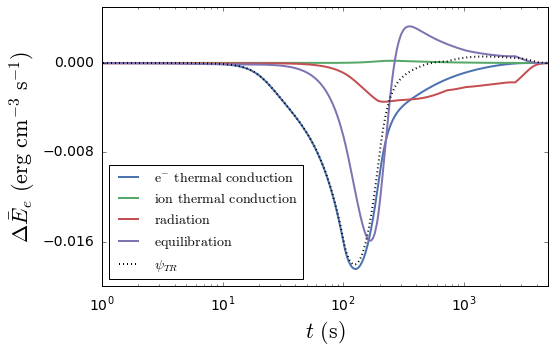

In [12]:
fig = plt.figure()
ax = fig.gca()
for i in range(len(delta_terms)):
        ax.plot(t,delta_terms[i],color=sns.color_palette('deep')[i],label=labels[i])
ax.plot(t,1.0/(config_dict['loop_length'])*1./(1.+Te/Ti)*(fce + (r3*(config_dict['loop_length'])*(n**2)*rad)-Te/Ti*fci),
       linestyle='dotted',color='k',label=r'$\psi_{TR}$')
ax.set_xscale('log')
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
ax.set_xlim([1,config_dict['total_time']])
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$\Delta\bar{E}_e$ $(\mathrm{erg}$ $\mathrm{cm}^{-3}$ $\mathrm{s}^{-1})$')
ax.legend(loc='best')
plt.savefig(__dest__)
plt.show()